# Актуальная ссылка на версию с графиками: https://colab.research.google.com/drive/1WIFE95sAiEjXpC2l71ws_22BYaGROcDd?usp=sharing
# Шаг 1. Выбор датасета

## Прошу прощения за скриншоты, забыл что гит не рисует графики через библиотеку plotly в notebook. В следующем дз буду использовать другую библиотеку.
Мы возьмем датасет с характеристиками пингвинов (https://huggingface.co/datasets/SIH/palmer-penguins) и попытаемся предсказать их вид на основе имеющихся данных. Для начала загрузим данные и сразу удалим пустые строки.

In [97]:
# !python -m pip install huggingface_hub
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split 
from sklearn.manifold import TSNE


df = pd.read_csv("hf://datasets/SIH/palmer-penguins/penguins.csv")
df = df.dropna().reset_index()
df


,index,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
4,5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...,...
328,339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
329,340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
330,341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
331,342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


# Шаг 2. Подготовка
У нас есть текстовые переменные и численные. Сразу выделим численные переменные и посмотрим на данные, чтобы визуально исключить outliers.

In [98]:
numeric_columns = ['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g','year']

fig = make_subplots(rows=5, cols=1, shared_xaxes=True, 
                    subplot_titles=numeric_columns)

for i in range(1,6):
    fig.add_trace(
        go.Bar(x=df.index, y=df[numeric_columns[i-1]],name=numeric_columns[i-1]),
        row=i, col=1
    )
    
fig.update_layout(height=600, width=1200, title_text="Exploring numeric features")

fig.show()

Визуально outlier-ы не обнаружены, давайте теперь взглянем на распределение этих переменных. Данных довольно мало, но все же видно, что bill_depth_mm и flipper_length_mm визуально напоминают бимодальное распределение, можно выдвинуть гипотезу о том, что это как раз хороший предиктор на классы. Также как-будто можно заметить три выраженных пика в переменной Вес, возможно пингвины разных видов в среднем отличаются по весу на 5-7 грамм. 

In [99]:
fig = make_subplots(rows=1, cols=5, shared_xaxes=True, 
                    subplot_titles=numeric_columns[:-1])

for i in range(1,5):
    fig.add_trace(
        go.Histogram(x=df[numeric_columns[i-1]],name=numeric_columns[i-1]),
        row=1, col=i
    )

fig.update_layout(height=600, width=1200, title_text="Exploring numeric features")

fig.show()

Видим текстовые переменные, сразу переводим их в dummy-пременные и разбиваем на выборки в отношении 0.7 к 0.1 к 0.2 ( тренировочный, валидация и тест соответственно). Целевой метрикой будет вид пингвина, из которого мы вычленим код для превращения текста в численную метрику.

In [100]:
numeric_columns = ['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g','year']
target_names = list(df['species'].unique())
df['species'] =  df['species'].astype('category').cat.codes
island_dummies = pd.get_dummies(df['island'], dtype=int)
sex_dummies = pd.get_dummies(df['sex'], dtype=int)

df = pd.concat([df[numeric_columns],df['species'],island_dummies,sex_dummies], axis=1)  
X = df.drop(columns=['species'])
y = df[['species']]

train_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 
X


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,Biscoe,Dream,Torgersen,female,male
0,39.1,18.7,181.0,3750.0,2007,0,0,1,0,1
1,39.5,17.4,186.0,3800.0,2007,0,0,1,1,0
2,40.3,18.0,195.0,3250.0,2007,0,0,1,1,0
3,36.7,19.3,193.0,3450.0,2007,0,0,1,1,0
4,39.3,20.6,190.0,3650.0,2007,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
328,55.8,19.8,207.0,4000.0,2009,0,1,0,0,1
329,43.5,18.1,202.0,3400.0,2009,0,1,0,1,0
330,49.6,18.2,193.0,3775.0,2009,0,1,0,0,1
331,50.8,19.0,210.0,4100.0,2009,0,1,0,0,1


# Шаг 3. Модели

Начнем с построения LogisticRegression модели. Мы видим, что точность модели на тестовой выборке стопроцентная, в то время как на тестовой и валидационной чуть ниже. macro-F1 очень высокий, все классы предсказываются хорошо. Интересно посмотреть, какое количество переменных реально определяют к какому виду относится пингвин. Чтобы визуально не регрессировать переменные на таргет, попробуем вывести веса каждой переменной в регрессии, чтобы разобраться в этом. Для этого находим сумму абсолютных величин коэфициентов и делим на это значение каждый коэфициент, пытаясь получить прокси-значение значимости наших переменных.
Мы видим, что 

* наиболее значимые признаки для  Adelie, - это bill_length_mm, bill_depth_mm и flipper_length_mm
* наиболее значимые признаки для  Gentoo, - это bill_length_mm и остров, на котором проживает вид ( Biscoe и Dream)
* наиболее значимые признаки для  Chinstrap, - это bill_depth_mm, flipper_length_mm и body_mass_g



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def print_metrics(split_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"{split_name}: accuracy={acc:.3f}, macro-F1={f1m:.3f}")

logreg_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        C=0.1,  
        max_iter=1000,
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=-1,
        random_state=111,
    )),
])


logreg_clf.fit(X_train, y_train)
for i in range(3):
    print(target_names[i], list(X_train.columns))
    total_regr_coef = sum(map(lambda x: abs(x),logreg_clf["logreg"].coef_[i]))
    print(list(map(lambda x: abs(x)/total_regr_coef, logreg_clf["logreg"].coef_[i])))

    
y_pred_train = logreg_clf.predict(X_train)
y_pred_test  = logreg_clf.predict(X_test)
y_pred_val = logreg_clf.predict(X_val)
cm = confusion_matrix(y_test, y_pred_test)
print_metrics("TRAIN", y_train, y_pred_train)
print_metrics("VAL  ", y_val,   y_pred_val)
print_metrics("TEST ", y_test,  y_pred_test)

fig = go.Figure(data=go.Heatmap(
    z=cm,
    x=target_names,
    y=target_names,
    colorscale='Blues', # Choose a color scale (e.g., 'Viridis', 'Plasma', 'Blues')
    hoverongaps=False,
    text=cm, # Add the actual numbers as text annotations
    texttemplate="%{text}",
    textfont={"size": 16}
))
fig.show()
print(classification_report(y_test, y_pred_test, target_names=target_names))


/Users/sergey/miniconda3/envs/mlf/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Adelie
['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'year', 'Biscoe', 'Dream', 'Torgersen', 'female', 'male']
[0.3717021080327335, 0.1448026331095471, 0.13263617883464685, 0.05843753330701571, 0.02941440735586495, 0.0009904977873893828, 0.05782498820032493, 0.0819253089115029, 0.061133172230487275, 0.06113317223048727]
Gentoo
['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'year', 'Biscoe', 'Dream', 'Torgersen', 'female', 'male']
[0.31012219705630695, 0.05585647673062387, 0.043858865372932335, 0.10460168543884146, 0.01592573912124582, 0.14720165672047814, 0.18904923315725158, 0.056336741563147594, 0.03852370241958613, 0.03852370241958609]
Chinstrap
['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'year', 'Biscoe', 'Dream', 'Torgersen', 'female', 'male']
[0.08063934604464996, 0.2061928045360603, 0.18164198609300525, 0.16439399661469176, 0.014904695977177041, 0.14459344678900982, 0.12675191985827158, 0.029660748528

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        32
      Gentoo       1.00      1.00      1.00        12
   Chinstrap       1.00      1.00      1.00        23

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



Теперь постром DecisionTreeClassifier. На прошлом этапе мы предположили, что есть несколько переменных, которые берут на себя основную роль в разделении выборки на классы. Если это так, то у дерева с 3 ветками не должны сильно упасть метрики предсказаний. Действительно, результат изменился довольно незначительно, если мы обратимся к дереву решений, то увидим, что в нем фигурируют те же самые поля, что мы обозначили в предыдущем шаге. 

TRAIN: accuracy=0.974, macro-F1=0.972
VAL  : accuracy=0.970, macro-F1=0.921
TEST : accuracy=0.970, macro-F1=0.969


[Text(0.5909090909090909, 0.875, 'flipper_length_mm <= 206.5\nentropy = 1.54\nsamples = 233\nvalue = [101, 53, 79]\nclass = Adelie'),
 Text(0.36363636363636365, 0.625, 'bill_length_mm <= 44.65\nentropy = 0.96\nsamples = 150\nvalue = [101, 48, 1]\nclass = Adelie'),
 Text(0.18181818181818182, 0.375, 'bill_depth_mm <= 17.35\nentropy = 0.28\nsamples = 104\nvalue = [99, 5, 0]\nclass = Adelie'),
 Text(0.09090909090909091, 0.125, 'entropy = 0.76\nsamples = 23\nvalue = [18, 5, 0]\nclass = Adelie'),
 Text(0.2727272727272727, 0.125, 'entropy = 0.0\nsamples = 81\nvalue = [81, 0, 0]\nclass = Adelie'),
 Text(0.5454545454545454, 0.375, 'Dream <= 0.5\nentropy = 0.41\nsamples = 46\nvalue = [2, 43, 1]\nclass = Gentoo'),
 Text(0.45454545454545453, 0.125, 'entropy = 0.92\nsamples = 3\nvalue = [2, 0, 1]\nclass = Adelie'),
 Text(0.6363636363636364, 0.125, 'entropy = 0.0\nsamples = 43\nvalue = [0, 43, 0]\nclass = Gentoo'),
 Text(0.8181818181818182, 0.625, 'bill_depth_mm <= 18.0\nentropy = 0.33\nsamples = 83

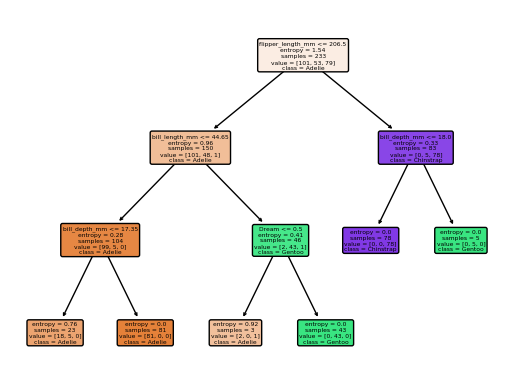

In [112]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf = clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_val = clf.predict(X_val)
print_metrics("TRAIN", y_train, y_pred_train)
print_metrics("VAL  ", y_val,   y_pred_val)
print_metrics("TEST ", y_test,  y_pred_test)
classification_report(y_test, y_pred_test, target_names=target_names)
plot_tree(clf, 
          feature_names=list(X.columns), 
          class_names=target_names,
          filled=True, 
          rounded=True, 
          precision=2)


Теперь в качестве эксперимента попробуем снизить глубину дерева до 2. В среднем, точность падает примерно на 1%. С учетом количества наблюдений и false-positive предсказаний, модели отличаются в предсказании 1 особи. Если мы опять взглянем на переменные, то обнаружим, что в дерево попадают переменные, которые мы выделили на этапе анализа данных как те, которые имеют бимодальное распределение. 

TRAIN: accuracy=0.966, macro-F1=0.961
TEST : accuracy=0.955, macro-F1=0.951
TEST : accuracy=0.955, macro-F1=0.951
              precision    recall  f1-score   support

      Adelie       1.00      0.91      0.95        32
      Gentoo       0.86      1.00      0.92        12
   Chinstrap       0.96      1.00      0.98        23

    accuracy                           0.96        67
   macro avg       0.94      0.97      0.95        67
weighted avg       0.96      0.96      0.96        67



[Text(0.5, 0.8333333333333334, 'flipper_length_mm <= 206.5\nentropy = 1.54\nsamples = 233\nvalue = [101, 53, 79]\nclass = Adelie'),
 Text(0.25, 0.5, 'bill_length_mm <= 44.65\nentropy = 0.96\nsamples = 150\nvalue = [101, 48, 1]\nclass = Adelie'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.28\nsamples = 104\nvalue = [99, 5, 0]\nclass = Adelie'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.41\nsamples = 46\nvalue = [2, 43, 1]\nclass = Gentoo'),
 Text(0.75, 0.5, 'bill_depth_mm <= 18.0\nentropy = 0.33\nsamples = 83\nvalue = [0, 5, 78]\nclass = Chinstrap'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.0\nsamples = 78\nvalue = [0, 0, 78]\nclass = Chinstrap'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.0\nsamples = 5\nvalue = [0, 5, 0]\nclass = Gentoo')]

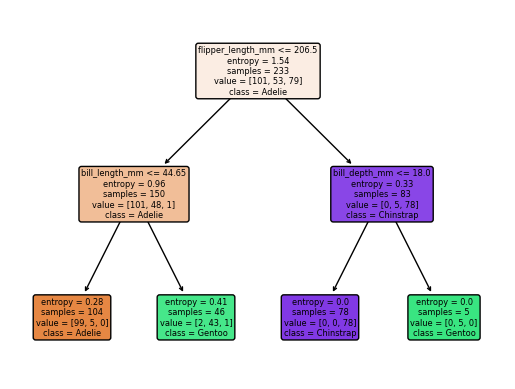

In [113]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=2)
clf = clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_val = clf.predict(X_val)
print_metrics("TRAIN", y_train, y_pred_train)
print_metrics("TEST ", y_test,  y_pred_test)
print_metrics("TEST ", y_test,  y_pred_test)
print(classification_report(y_test, y_pred_test, target_names=target_names))
plot_tree(clf, 
          feature_names=list(X.columns), 
          class_names=target_names,
          filled=True, 
          rounded=True, 
          precision=2)

# Итог
Мы рассмотрели различные модели для классификации. На данном датасете и DecisionTreeClassifier и LogisticRegression показали хорошие результаты с высокой точностью прогноза. Переменными с самым большим прогностическим потенциалом оказались bill_length_mm, bill_depth_mm и flipper_length_mm, мы сделали предположение о их высокой полезности на этапе изучения распределения данных и подтвердили это анализом коэфициентов обеих моделей. 
